This notebook generates the stress histograms of different voter types. So, are republicans or democrats more stressed?

In [1]:
""" BORING!!! """
%load_ext autoreload
%autoreload 2
import numpy as np
import pyreadstat as prs
import sys
sys.path.append('../src')
from clean_data_1 import *
from clean_data_2 import transform_dataframe_2
from make_belief_network import make_belief_network
from calc_stress import stress
from interpret_belief_vector import interpret_belief_vector

In [2]:
""" Importing the data!!! """
import pyreadstat as prs
raw_df, meta = prs.read_sas7bdat("../dat/gss7222_r3.sas7bdat")

In [36]:
""" Cleaning the data and setting the replicating core """
import sys
sys.path.append('../src')
from clean_data_1 import transform_dataframe_1
 
# Clean data 
df, original_metadata = transform_dataframe_1(raw_df)    

# Set variables of interest
variables = ["PARTYID","POLVIEWS","NATSPAC","NATENVIR","NATHEAL","NATCITY","NATCRIME","NATDRUG","NATEDUC","NATRACE","NATARMS",
"NATAID","NATFARE","NATROAD","NATSOC","NATMASS","NATPARK","NATCHLD","NATSCI","EQWLTH","SPKATH","COLATH","LIBATH","SPKRAC","COLRAC","LIBRAC","SPKCOM","COLCOM","LIBCOM","SPKMIL","COLMIL","LIBMIL","SPKHOMO",
"COLHOMO","LIBHOMO","SPKMSLM","COLMSLM","LIBMSLM","CAPPUN","GUNLAW","COURTS","GRASS","ATTEND","RELITEN","POSTLIFE","PRAYER","AFFRMACT","WRKWAYUP","HELPFUL",
"FAIR","TRUST","CONFINAN","CONBUS","CONCLERG","CONEDUC","CONFED","CONLABOR","CONPRESS","CONMEDIC","CONTV","CONJUDGE","CONSCI","CONLEGIS","CONARMY","GETAHEAD","FEPOL","ABDEFECT","ABNOMORE","ABHLTH","ABPOOR","ABRAPE","ABSINGLE","ABANY","SEXEDUC","DIVLAW","PREMARSX","TEENSEX","XMARSEX","HOMOSEX","PORNLAW",
"SPANKING","LETDIE1","SUICIDE1","SUICIDE2","POLHITOK","POLABUSE","POLMURDR","POLESCAP","POLATTAK","NEWS","TVHOURS","FECHLD","FEPRESCH","FEFAM","RACDIF1","RACDIF2","RACDIF3",
"RACDIF4","HELPPOOR","MARHOMO", "PRESLAST_NONCONFORM", "PRESLAST_DEMREP", "VOTELAST", "BALLOT"]


In [62]:

start_year = 1990
timeframe = list(range(start_year, start_year+8))

BN, variables_list, correlation_matrix_partial = make_belief_network(df, variables, timeframe, method="spearman", is_partial=True, threshold=0, sample_threshold=0, regularisation=0.2)



In [84]:
""" In order to calculate the stress of beleif vectors, we need to belief vectors """
""" We first clear the dataset again to implement the median solution """

df_b_vecs, meta_data_minsmaxs = transform_dataframe_2(df, original_metadata, timeframe)

""" First we replace all NaNs with zero """
df_b_vecs = df_b_vecs.fillna(0)

""" Then we normalise the data to span -1 and 1 """

df_b_vecs = normalise_columns(df_b_vecs, meta_data_minsmaxs)


""" We can then cut the data down to only the variables in the belief network """

df_b_vecs = df_b_vecs[variables_list]

""" And then split into the variables we want to condition on, for example, ballots 1, 2, and 3 """

""" Interesting variables: "SPKATH","COLATH","LIBATH","SPKRAC","COLRAC","LIBRAC","SPKCOM","COLCOM","LIBCOM","SPKMIL","COLMIL","LIBMIL","SPKHOMO",
"COLHOMO","LIBHOMO","SPKMSLM","COLMSLM","LIBMSLM" """

var_for_split = "BALLOT"

# print(df[var_for_split].value_counts())
# print(df_b_vecs[var_for_split].value_counts())

df_ballot_1 = df_b_vecs[df_b_vecs[var_for_split] == 1]
df_ballot_2 = df_b_vecs[df_b_vecs[var_for_split] == 2]
df_ballot_3 = df_b_vecs[df_b_vecs[var_for_split] == 3]

""" And then get arrays for the belief vectors """

belief_vec_ballot_1 = df_ballot_1.to_numpy()
belief_vec_ballot_2 = df_ballot_2.to_numpy()
belief_vec_ballot_3 = df_ballot_3.to_numpy()

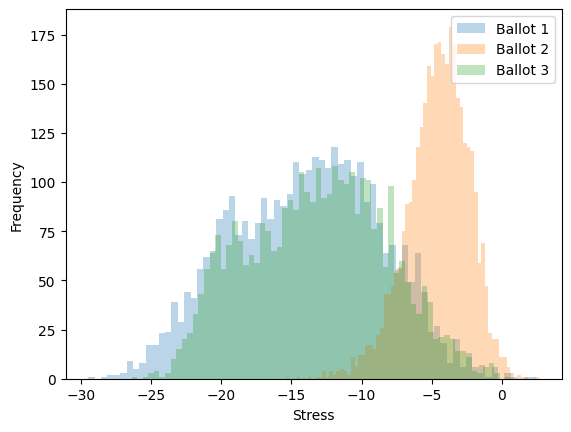

In [86]:
""" Okay, and now we calculate the stress of the belief vectors """

correlation_matrix_noDiag = correlation_matrix_partial - np.eye(correlation_matrix_partial.shape[0])

b1_stress_vec = []
b2_stress_vec = []
b3_stress_vec = []

b1_stress_vec = [stress(belief_vec_ballot_1[i,:], correlation_matrix_noDiag) for i in range(belief_vec_ballot_1.shape[0])]
b2_stress_vec = [stress(belief_vec_ballot_2[i,:], correlation_matrix_noDiag) for i in range(belief_vec_ballot_2.shape[0])]
b3_stress_vec = [stress(belief_vec_ballot_3[i,:], correlation_matrix_noDiag) for i in range(belief_vec_ballot_3.shape[0])]

summed_stress_vec = b1_stress_vec + b2_stress_vec + b3_stress_vec 

# print("Number of belief vectors: ", len(summed_stress_vec))

""" We can also compare it to a random set of belief vectors """

# Generate K random belief vectors
# random_belief_vectors = np.random.choice([-1, 0, 1], size=(len(stress_vec), len(variables_list)))
# alt_belief_vectors = np.random.rand(len(repub_stress_vec)+len(dem_stress_vec), len(variables_list))*2 - 1
# alt_stress_vec = [stress(vector, correlation_matrix_partial) for vector in random_belief_vectors]

""" We can also compare the stress vectors of republican and democrat belief vectors """


import matplotlib.pyplot as plt
bin_resolution = 50
# plt.hist(summed_stress_vec, bins=round(len(summed_stress_vec)/bin_resolution), alpha=0.3, label='Summed belief vectors', density=False)
# plt.hist(alt_stress_vec, bins=100, alpha=0.3, label='Random belief vectors', density=True)
plt.hist(b1_stress_vec, bins=round(len(b1_stress_vec)/bin_resolution), alpha=0.3, label='Ballot 1', density=False)
plt.hist(b2_stress_vec, bins=round(len(b2_stress_vec)/bin_resolution), alpha=0.3, label='Ballot 2', density=False)
plt.hist(b3_stress_vec, bins=round(len(b3_stress_vec)/bin_resolution), alpha=0.3, label='Ballot 3', density=False)

plt.legend(loc='upper right')
plt.xlabel('Stress')
plt.ylabel('Frequency')
plt.show()

# print("Number of belief vectors: ", len(summed_stress_vec))